In [1]:
import numpy as np
import matplotlib.pyplot as plt
from profit.sur.backend.gp_functions import invert, nll, predict_f
from profit.sur.backend.kernels import kern_sqexp
from profit.util.halton import halton


In [2]:
def f(x): return x*np.cos(10*x)

# Custom function to build GP matrix
def build_K(xa, xb, hyp, K):
    for i in np.arange(len(xa)):
        for j in np.arange(len(xb)):
            K[i, j] = kern_sqexp(xa[i], xb[j], hyp[0])

noise_train = 0.01

ntrain = 20
xtrain = halton(1, ntrain)
ftrain = f(xtrain)
np.random.seed(0)
ytrain = ftrain + noise_train*np.random.randn(ntrain, 1)

In [3]:
# GP regression with fixed kernel hyperparameters
hyp = [0.5, 1e-6]  # l and sig_noise**2

K = np.empty((ntrain, ntrain))   # train-train
build_K(xtrain, xtrain, hyp, K)  # writes inside K
Ky = K + hyp[-1]*np.eye(ntrain)
Kyinv = invert(Ky, 4, 1e-6)       # using gp_functions.invert

ntest = 10
xtest = np.linspace(0, 1, ntest)
ftest = f(xtest)

Ks = np.empty((ntrain, ntest))  # train-test
Kss = np.empty((ntest, ntest))  # test-test
build_K(xtrain, xtest, hyp, Ks)
build_K(xtest, xtest, hyp, Kss)

fmean = Ks.T.dot(Kyinv.dot(ytrain)) # predictive mean


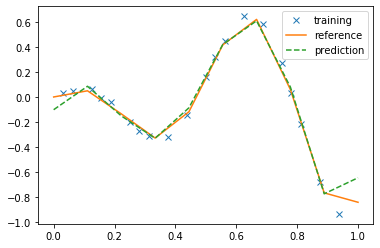

In [4]:
plt.figure()
plt.plot(xtrain, ytrain, 'x')
plt.plot(xtest, ftest, '-')
plt.plot(xtest, fmean, '--')
plt.legend(('training', 'reference', 'prediction'))

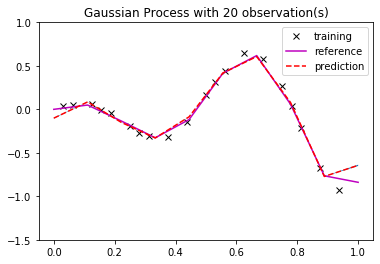

In [5]:
Ef, varf = predict_f(hyp, xtrain.reshape(-1, 1),
                      ytrain.reshape(-1, 1), xtest.reshape(-1, 1), neig=8)# posterior Estimation and variance
varf = np.diag(varf)

# we keep only the diag because the variance is on it, the other terms are covariance


plt.plot(xtrain, ytrain, 'kx')
plt.plot(xtest, ftest, 'm-')
plt.plot(xtest, fmean, 'r--')
axes = plt.gca()
axes.set_ylim([-1.5, 1])
plt.title('Gaussian Process with '+ str(ntrain) + ' observation(s)')
plt.legend(('training', 'reference', 'prediction'))



plt.fill_between(xtest, # x
                 (fmean.flatten() + 2 * np.sqrt(varf)), # y1
                 (fmean.flatten() - 2 * np.sqrt(varf))) # y2

In [6]:
# Negative log likelihood over length scale
ls = np.linspace(1e-3, 3, 50)
nlls = np.array(
    [nll([l, 0.00694534], xtrain, ytrain, 0) for l in ls]
    ).flatten()

Text(0.5, 1.0, 'Negative log-likelihood')

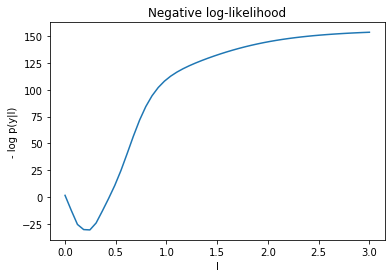

In [7]:
plt.figure()
plt.plot(ls, nlls)
plt.xlabel('l')
plt.ylabel('- log p(y|l)')
plt.title('Negative log-likelihood')

In [44]:
from scipy.optimize import minimize

def nll_transform(log10hyp):
    hyp = 10**log10hyp
    return nll(hyp, xtrain, ytrain, 0)

res = minimize(nll_transform, np.array([0, -6]), method='BFGS')

In [45]:
print(res)
#hyp = 10**res.x
print('[l,sig2] = ', 10**res.x)
print('[log_l, log_s2] = ', res.x)
log_l = res.x[0]
log_s2= res.x[1]
log_hyp = [log_l, log_s2]

new_hyp = [10**res.x[0], 10**res.x[1]]
hess_inv = res.hess_inv
print("\nhess_inv = ", hess_inv)
print("\nhess = ", invert(hess_inv))

      fun: -51.35427379159095
 hess_inv: array([[0.00129113, 0.00049261],
       [0.00049261, 0.03422863]])
      jac: array([3.95774841e-05, 1.57356262e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 268
      nit: 19
     njev: 65
   status: 2
  success: False
        x: array([-0.64803431, -4.02323524])
[l,sig2] =  [2.24887695e-01 9.47904880e-05]
[log_l, log_s2] =  [-0.64803431 -4.02323524]

hess_inv =  [[0.00129113 0.00049261]
 [0.00049261 0.03422863]]

hess =  [[778.79414511 -11.20816998]
 [-11.20816998  29.37661016]]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1592: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  RuntimeWarning)


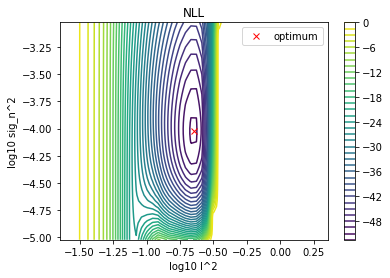

In [11]:
nl = 50
ns2 = 40

log10l = np.linspace(res.x[0]-1, res.x[0]+1, nl)
log10s2 = np.linspace(res.x[1]-1, res.x[1]+1, ns2)
[Ll, Ls2] = np.meshgrid(log10l, log10s2)

nlls = np.array(
    [nll([10**ll, 10**ls2], xtrain, ytrain, 0) for ls2 in log10s2 for ll in log10l]
    ).reshape([ns2, nl])
    
# Do some cut for visualization
maxval = 0.0
nlls[nlls>maxval] = maxval

plt.figure()
plt.title('NLL')
plt.contour(Ll, Ls2, nlls, levels=50)
plt.plot(res.x[0], res.x[1], 'rx')
plt.xlabel('log10 l^2')
plt.ylabel('log10 sig_n^2')
plt.colorbar()
plt.legend(['optimum'])
plt.show()

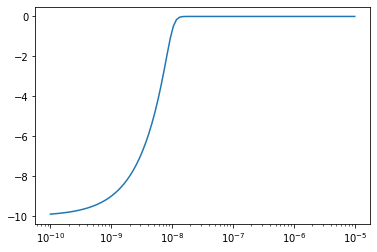

In [12]:
# Trying out priors to cut values

def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x))

def prior(hyp):
    return sigmoid(hyp[0]-6)*sigmoid(hyp[-1]-6)

x = np.logspace(-10, -5, 100)
plt.semilogx(x, np.log(sigmoid(1e9*x - 10)))

In [13]:
from profit.sur.backend.gp_functions import k

def dk_logdl(xa, xb, l): # derivative of the kernel w.r.t log lengthscale
    dk_dl = ((xa - xb)**2.0 * np.exp(-(xa-xb)**2.0/(2 * l**2))) / l**3 
    dk_logdl = dk_dl * np.log(10) * 10**log_l # from log lengthscale to lengthscale
    return dk_logdl
    

def dkdl(xa, xb, l): # derivative of the kernel w.r.t lengthscale
    dk_dl = ((xa - xb)**2.0 * np.exp(-(xa-xb)**2.0/(2 * l**2))) / l**3 
    return dk_dl

In [15]:

log_K = np.empty((ntrain, ntrain))
for i in np.arange(len(xtrain)):
    
    for j in np.arange(len(xtrain)):
        log_K[i, j] = k(xtrain[i], xtrain[j], log_hyp[0])


log_K_star = np.empty((ntest, ntrain))
for i in np.arange(len(xtest)):
    for j in np.arange(len(xtrain)):
        log_K_star[i, j] = k(xtest[i], xtrain[j], log_hyp[0])


log_K_prime = np.empty((ntrain, ntrain))
for i in np.arange(len(xtrain)):
    for j in np.arange(len(xtrain)):
        log_K_prime[i, j] = dk_logdl(xtrain[i], xtrain[j], log_hyp[0])


log_K_star_prime = np.empty((ntest, ntrain))
for i in np.arange(len(xtest)):
    for j in np.arange(len(xtrain)):
        log_K_star_prime[i, j] = dk_logdl(xtest[i], xtrain[j], log_hyp[0])




# K.shape = (20, 20)
# K_prime.shape = (20, 20)

# K_star.shape = (10, 20)
# K_star_prime.shape = (10, 20)

In [17]:




alpha = np.dot(Kyinv, ytrain) # RW p17 paragraph 4

log_dalpha_dl = -Kyinv.dot(log_K_prime)\
    .dot(Kyinv)\
    .dot(ytrain)

log_dalpha_ds = -Kyinv.dot(np.log(10) * 10**log_s2 * np.eye(ntrain)).dot(Kyinv).dot(ytrain) # - Kyinv x ln(10) x 10^log_sigma x I x Kyinv x ytrain 

log_dm = np.empty((ntest,len(hyp), 1))

for nb_hyp in range(len(hyp)):
    if nb_hyp == 0 :
        log_dm[:,nb_hyp,:] = np.dot(log_K_star_prime, alpha) -\
                         np.dot(log_K_star, log_dalpha_dl) 
    else : 
        log_dm[:,nb_hyp,:] = np.dot(log_K_star, log_dalpha_ds)

print("\n\n\ndm :",log_dm.shape, "\n\n")
#print(dm)

    







dm : (10, 2, 1) 




In [36]:
log_sigma = invert(hess_inv) # define the sigma matrix as the inverse of hess_inv
V = varf # set V as the result of the predict_f diagonal  

print("\nsigma shape : ", log_sigma.shape)
print(log_sigma)
print("dm.shape : ", log_dm.shape)


log_dm_transpose = np.empty((ntest, 1, len(log_hyp)))
log_dmT_dot_sigma = np.empty((ntest, 1, len(log_hyp)))
log_dmT_dot_sigma_dot_dm = np.empty((ntest, 1))



for i in range(ntest):
    log_dm_transpose[i] = log_dm[i].T
    print("\n\ndm.t",i,' : ', log_dm_transpose[i])
    log_dmT_dot_sigma[i] = log_dm_transpose[i].dot(log_sigma)
    print("sigma = ", log_sigma)
    print("dmT_dot_sigma",i," : ", log_dmT_dot_sigma[i])
    log_dmT_dot_sigma_dot_dm[i] = log_dmT_dot_sigma[i].dot(log_dm[i])
    #print("dmT_dot_sigma_dot_dm",i," : ", dmT_dot_sigma_dot_dm[i])
    
# print("dm_transpose :", dm_transpose.shape)
# print("\ndmT_dot_sigma ", dmT_dot_sigma.shape)
# print("dmT_dot_sigma_dot_dm ", dmT_dot_sigma_dot_dm.shape)
# print("V ", V.shape)


 
log_V_tild = V.reshape((ntest,1)) + log_dmT_dot_sigma_dot_dm # Osborne et al. (2012) Active learning eq.19 


print("V_tild.shape ", V_tild.shape)
print("\n\n\tMarginal variance\n\n", log_V_tild )





sigma shape :  (2, 2)
[[778.79414511 -11.20816998]
 [-11.20816998  29.37661016]]
dm.shape :  (10, 2, 1)


dm.t 0  :  [[ -20.25535304 -560.80493934]]
sigma =  [[778.79414511 -11.20816998]
 [-11.20816998  29.37661016]]
dmT_dot_sigma 0  :  [[ -9489.15327069 -16247.52263642]]


dm.t 1  :  [[ -20.37309561 -379.68301432]]
sigma =  [[778.79414511 -11.20816998]
 [-11.20816998  29.37661016]]
dmT_dot_sigma 1  :  [[-11610.89581869 -10925.45477577]]


dm.t 2  :  [[ -21.49666592 -247.72696033]]
sigma =  [[778.79414511 -11.20816998]
 [-11.20816998  29.37661016]]
dmT_dot_sigma 2  :  [[-13964.91168121  -7036.44005305]]


dm.t 3  :  [[ -24.1516403  -160.30990848]]
sigma =  [[778.79414511 -11.20816998]
 [-11.20816998  29.37661016]]
dmT_dot_sigma 3  :  [[-17012.37535814  -4438.66599575]]


dm.t 4  :  [[ -28.52210952 -110.87950601]]
sigma =  [[778.79414511 -11.20816998]
 [-11.20816998  29.37661016]]
dmT_dot_sigma 4  :  [[-20970.09555221  -2937.58337055]]


dm.t 5  :  [[-34.34358521 -93.07684358]]
sigma =

In [157]:
# Step 1 : invert the res.hess_inv to get H_tilde

H_tilde = invert(hess_inv)
new_hyp = hyp # new_hyp = Initial Hyp
#new_hyp = [10**res.x[0], 10**res.x[1]]
# Step 2 Get H 


H = np.empty((len(H_tilde), len(H_tilde)))
for i in np.arange(len(H_tilde)):
    for j in np.arange(len(H_tilde)):
        H[i,j] = (1/np.log(10)**2) * H_tilde[i,j]/(new_hyp[i]*new_hyp[j])

# Step 3 get Sigma
H_inv = invert(H)
sigma_m = H_inv


In [158]:

K = np.empty((ntrain, ntrain))
for i in np.arange(len(xtrain)):
    for j in np.arange(len(xtrain)):
        K[i, j] = k(xtrain[i], xtrain[j], new_hyp[0])


K_star = np.empty((ntest, ntrain))
for i in np.arange(len(xtest)):
    for j in np.arange(len(xtrain)):
        K_star[i, j] = k(xtest[i], xtrain[j], new_hyp[0])


K_prime = np.empty((ntrain, ntrain))
for i in np.arange(len(xtrain)):
    for j in np.arange(len(xtrain)):
        K_prime[i, j] = dkdl(xtrain[i], xtrain[j], new_hyp[0])


K_star_prime = np.empty((ntest, ntrain))
for i in np.arange(len(xtest)):
    for j in np.arange(len(xtrain)):
        K_star_prime[i, j] = dkdl(xtest[i], xtrain[j], new_hyp[0])
        

In [159]:
alpha = np.dot(Kyinv, ytrain) # RW p17 paragraph 4

dalpha_dl = -Kyinv.dot(K_prime)\
    .dot(Kyinv)\
    .dot(ytrain)

dalpha_ds = -Kyinv.dot(np.eye(ntrain)).dot(Kyinv).dot(ytrain) # - Kyinv x I x Kyinv x ytrain 

dm = np.empty((ntest,len(hyp), 1))

# print("KStar' ", K_star_prime)
# print("\n\nKyinv ", Kyinv)
# print("ytrain ", ytrain)

for nb_hyp in range(len(hyp)):
    if nb_hyp == 0 :
        dm[:,nb_hyp,:] = np.dot(K_star_prime, alpha) -\
                         np.dot(K_star, dalpha_dl) 
    else : 
        dm[:,nb_hyp,:] = np.dot(K_star, dalpha_ds)

#print("\n\n\ndm :",dm.shape, "\n\n")
#print(dm)

In [160]:

V = varf # set V as the result of the predict_f diagonal  

# print("\nsigma shape : ", sigma.shape)
print(sigma_m)
# print("dm.shape : ", dm.shape)
# print("new_hyp = ", new_hyp)


dm_transpose = np.empty((ntest, 1, len(hyp)))
dmT_dot_sigma = np.empty((ntest, 1, len(hyp)))
dmT_dot_sigma_dot_dm = np.empty((ntest, 1))


for i in range(ntest):
    dm_transpose[i] = dm[i].T
    #print("dm = ", dm)
    print("\n\ndm.t",i,' : ', dm_transpose[i])
    #print("sigma = ", sigma_m)
    dmT_dot_sigma[i] = dm_transpose[i].dot(sigma_m)
    #print("dmT_dot_sigma",i," : ",dmT_dot_sigma[i])
    dmT_dot_sigma_dot_dm[i] = dmT_dot_sigma[i].dot(dm[i])
    #print("dmT_dot_sigma_dot_dm",i," : ", dmT_dot_sigma_dot_dm[i])
    
# print("dm_transpose :", dm_transpose.shape)
# print("\ndmT_dot_sigma ", dmT_dot_sigma.shape)
# print("dmT_dot_sigma_dot_dm ", dmT_dot_sigma_dot_dm.shape)
# print("V ", V.shape)


 
V_tild = V.reshape((ntest,1)) + dmT_dot_sigma_dot_dm # Osborne et al. (2012) Active learning eq.19 


# print("V_tild.shape ", V_tild.shape)
print("\n\n\tMarginal variance\n\n", V_tild )



[[1.71135440e-03 1.30587913e-09]
 [1.30587913e-09 1.81476730e-13]]


dm.t 0  :  [[-4.36131755e+01 -4.45847918e+04]]


dm.t 1  :  [[  -37.33122835 11233.97226906]]


dm.t 2  :  [[ 5.21937486e+00 -7.57721168e+03]]


dm.t 3  :  [[   36.86068962 -2134.85121918]]


dm.t 4  :  [[   23.8631202  10432.47071457]]


dm.t 5  :  [[-24.97452891 914.88668823]]


dm.t 6  :  [[   -61.24737115 -12953.00486183]]


dm.t 7  :  [[-32.69929722 825.76279831]]


dm.t 8  :  [[   73.52810692 12734.24966621]]


dm.t 9  :  [[   212.79158183 -96823.94489288]]


	Marginal variance

 [[3.26062532e+00]
 [2.38390671e+00]
 [4.65278583e-02]
 [2.32503064e+00]
 [9.75198415e-01]
 [1.06735881e+00]
 [6.42180464e+00]
 [1.82978535e+00]
 [9.25471182e+00]
 [7.74384713e+01]]


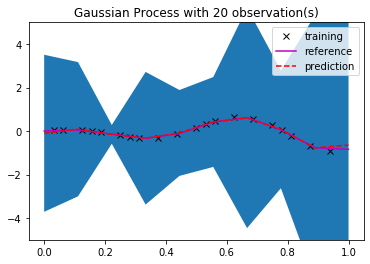

In [161]:

plt.plot(xtrain, ytrain, 'kx')
plt.plot(xtest, ftest, 'm-')
plt.plot(xtest, fmean, 'r--')
axes = plt.gca()
axes.set_ylim([-5, 5])
plt.title('Gaussian Process with '+ str(ntrain) + ' observation(s)')
plt.legend(('training', 'reference', 'prediction'))



plt.fill_between(xtest, # x
                 (fmean.flatten() + 2 * np.sqrt(V_tild.flatten())), # y1
                 (fmean.flatten() - 2 * np.sqrt(V_tild.flatten()))) # y2


In [152]:
result = minimize(nll, hyp, args=(xtrain, ytrain), method='BFGS') 
# Got Identity matrix as hessian with L-BFGS-B

wld_hyp = result.x
# print(result) 


In [153]:
wld_K = np.empty((ntrain, ntrain))
for i in np.arange(len(xtrain)):
    
    for j in np.arange(len(xtrain)):
        wld_K[i, j] = k(xtrain[i], xtrain[j], wld_hyp[0])


wld_K_star = np.empty((ntest, ntrain))
for i in np.arange(len(xtest)):
    for j in np.arange(len(xtrain)):
        wld_K_star[i, j] = k(xtest[i], xtrain[j], wld_hyp[0])


wld_K_prime = np.empty((ntrain, ntrain))
for i in np.arange(len(xtrain)):
    for j in np.arange(len(xtrain)):
        wld_K_prime[i, j] = dkdl(xtrain[i], xtrain[j], wld_hyp[0])


wld_K_star_prime = np.empty((ntest, ntrain))
for i in np.arange(len(xtest)):
    for j in np.arange(len(xtrain)):
        wld_K_star_prime[i, j] = dkdl(xtest[i], xtrain[j], wld_hyp[0])


In [154]:
wld_alpha = np.dot(Kyinv, ytrain) # RW p17 paragraph 4

wld_dalpha_dl = -Kyinv.dot(K_prime)\
    .dot(Kyinv)\
    .dot(ytrain)

wld_dalpha_ds = -Kyinv.dot(np.eye(ntrain)).dot(Kyinv).dot(ytrain) # - Kyinv x I x Kyinv x ytrain 

wld_dm = np.empty((ntest,len(hyp), 1))

# print("KStar' ", K_star_prime)
# print("\n\nKyinv ", Kyinv)
# print("ytrain ", ytrain)

for nb_hyp in range(len(hyp)):
    if nb_hyp == 0 :
        wld_dm[:,nb_hyp,:] = np.dot(wld_K_star_prime, wld_alpha) -\
                         np.dot(wld_K_star, wld_dalpha_dl) 
    else : 
        wld_dm[:,nb_hyp,:] = np.dot(wld_K_star, wld_dalpha_ds)
        

In [156]:
V = varf # set V as the result of the predict_f diagonal  

wld_sigma = invert(result.hess_inv)



wld_dm_transpose = np.empty((ntest, 1, len(hyp)))
wld_dmT_dot_sigma = np.empty((ntest, 1, len(hyp)))
wld_dmT_dot_sigma_dot_dm = np.empty((ntest, 1))


for i in range(ntest):
    wld_dm_transpose[i] = wld_dm[i].T
    #print("dm = ", dm)
    #print("\n\nwld_dm.t",i,' : ', wld_dm_transpose[i])
    #print("wld_sigma = ", wld_sigma)
    wld_dmT_dot_sigma[i] = wld_dm_transpose[i].dot(wld_sigma)
    #print("wld_dmT_dot_sigma",i," : ",wld_dmT_dot_sigma[i])
    wld_dmT_dot_sigma_dot_dm[i] = wld_dmT_dot_sigma[i].dot(wld_dm[i])
    #print("wld_dmT_dot_sigma_dot_dm",i," : ", wld_dmT_dot_sigma_dot_dm[i])
    




 
wld_V_tild = V.reshape((ntest,1)) + wld_dmT_dot_sigma_dot_dm # Osborne et al. (2012) Active learning eq.19 


# print("V_tild.shape ", V_tild.shape)
print("\n\n\tMarginal variance\n\n", wld_V_tild )




	Marginal variance

 [[3.54366207e+23]
 [7.28180966e+23]
 [2.04186188e+24]
 [7.11169120e+23]
 [3.55059350e+24]
 [2.79008045e+23]
 [2.56483042e+24]
 [1.24196322e+22]
 [7.65660147e+23]
 [1.63860994e+22]]


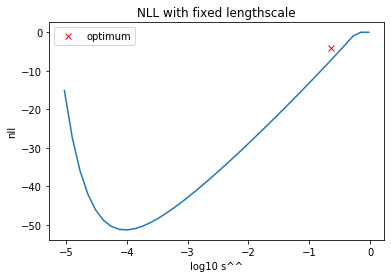

In [60]:
nl = 50
ns2 = 40


log10s2 = np.linspace(res.x[1]-1, res.x[1]+4, ns2)
[Ll, Ls2] = np.meshgrid(log10l, log10s2)

nlls = np.array(
    [nll([10**log_l, 10**ls2], xtrain, ytrain, 0) for ls2 in log10s2]
    ).reshape([ns2, 1])
    
# Do some cut for visualization
maxval = 0.0
nlls[nlls>maxval] = maxval

plt.figure()
plt.title('NLL with fixed lengthscale')
plt.plot(res.x[0], res.x[1], 'rx')
plt.plot(log10s2, nlls)
plt.xlabel('log10 s^^')
plt.ylabel('nll')
plt.legend(['optimum'])
plt.show()

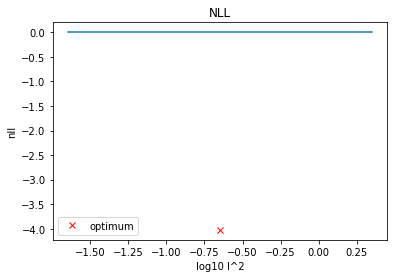

In [62]:
nl = 50
ns2 = 40

log10l = np.linspace(res.x[0]-1, res.x[0]+1, nl)

[Ll, Ls2] = np.meshgrid(log10l, log10s2)

nlls = np.array(
    [nll([10**ll, log_s2], xtrain, ytrain, 0) for ll in log10l]
    ).reshape([nl, 1])
    
# Do some cut for visualization
maxval = 0.0
nlls[nlls>maxval] = maxval

plt.figure()
plt.title('NLL')

plt.plot(res.x[0], res.x[1], 'rx')
plt.plot(log10l, nlls)
plt.xlabel('log10 l^2')
plt.ylabel('nll')
plt.legend(['optimum'])
plt.show()


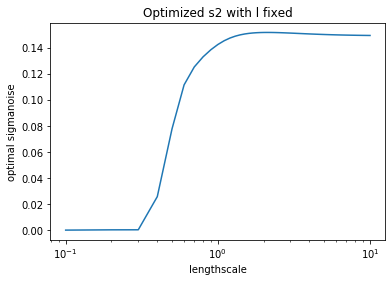

In [132]:

def nll_fixed_l(new_s2, new_l): 
    return nll([new_l, new_s2], xtrain, ytrain, 0)

lengthscale = np.linspace(0.1,10,100)
sigma_noise = []

for i in lengthscale:
    opti = minimize(nll_fixed_l,1e-8, args=(i), method='BFGS')
    sigma_noise.append(opti.x.item())

plt.figure()
plt.title('Optimized s2 with l fixed')
plt.semilogx(lengthscale, sigma_noise)
plt.xlabel('lengthscale')
plt.ylabel('optimal sigmanoise')
plt.savefig('fixed_l')
plt.show()

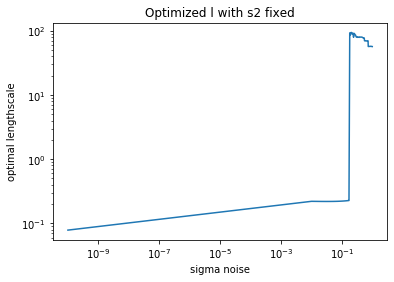

In [134]:
def nll_fixed_s2(new_l, new_s2): 
    return nll([new_l, new_s2], xtrain, ytrain, 0)

lengthscale = []
sigma_noise = np.linspace(1e-10, 1, 100)

for i in sigma_noise:
    opti = minimize(nll_fixed_s2,0.1, args=(i), method='BFGS')
    lengthscale.append(opti.x.item())
    #print("\n\n\n",opti)

plt.figure()
plt.title('Optimized l with s2 fixed')
plt.plot(sigma_noise, lengthscale)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('sigma noise')
plt.ylabel('optimal lengthscale')
plt.savefig('fixed_s2')
plt.show()
